# Fun With Two-Player Games

We have the following game:

1. We have two players;
2. Each player draws two numbers at random, and in secret, from a uniform distribution;
3. Each player chooses one of their two numbers;
4. The players each reveal their number;
5. Denoting the larger value as $L$ and the smaller value as $S$, If $L \geq 3S$ the larger number wins. Otherwise, the smaller number wins.

The question as asked in the above post is: "given any two numbers, which should one choose?".

One way of solving this problem is using the score function estimator:

$$\nabla_{\theta}J(\theta) = \int_{x}\nabla_{\theta} \log p_{\theta}(x) \,f(x)dx$$

And using gradient ascent step the weights in the direction that maximizes $f(x)$. To do this, we'll parameterize the weights $\theta$ of $p_{\theta}(x)$ with a neural net. The network will take in a set of two values that we'll call the state, and -- since we have a discrete set of choices -- will output scores over those two values using a softmax function. We'll use these scores to create a categorical distribution, and sample from it to choose one of the numbers. Since the numbers are private, the network will only be able to see its own numbers, and not anybody else's.

This function is often seen in Reinforcement Learning, where it's known as the Policy gradient. Our $f(x)$ in this case will be the function that determines whether or not we win or lose the game given the number that we pick.

First off, I'll import the dependencies. Since we're using a neural net, I'll be using PyTorch to do most of the heavy lifting:

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.optim as optim
import matplotlib.pyplot as plt

### The Policy Class
Next up, I'll define the Policy class. This class inherits from torch.nn.Module, and has a single, fully connected hidden layer with a tanh activation function (see the forward function). The update function implements the score function estimator above, and torch's autodifferentiation pushes it back through the computation graph. I've written a select_action function as well to handle sampling from the distribution, and getting the log-probability of the action.

In [2]:
class Policy(torch.nn.Module):
    """
    Our policy parameterizes a categorical distribution over the two number choices. We sample from this
    distribution, and then use a standard score function estimator to train our policy. We estimate the 
    gradient over many actions, and step the parameter weights in the direction that maximizes the chance
    of winning.
    """
    def __init__(self, inputs, hiddens, outputs):
        """
        Initialize fully connected layer, score output layer.
        """
        super(Policy,self).__init__()
        self.__fc = torch.nn.Linear(inputs, hiddens)
        self.__scores = torch.nn.Linear(hiddens, outputs)
        
    def forward(self, state):
        """
        Use tanh activation in hidden layer, softmax at output layer.
        """
        x = F.tanh(self.__fc(state))
        scores = self.__scores(x)
        return F.softmax(scores, dim=1)

    def select_action(self, state):
        """
        Get scores, create and sample from a categorical distribution using said scores.
        We need both the action and the log probability for the gradient.
        """
        scores = self.forward(state)
        dist = Categorical(scores)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return action.data[0], logprob

    def update(self, opt, batch):
        """
        Update weights in the network using grad J(theta) = -E[grad logprob_{theta}(x)*f(x)]
        """
        rewards = torch.Tensor(batch["rewards"])
        logprobs = torch.cat(batch["logprobs"],dim=0)
        rewards = (rewards-rewards.mean())/(rewards.std()+1e-10)
        loss = torch.sum(-logprobs*rewards)
        opt.zero_grad()
        loss.backward()
        opt.step()

### Helper Functions

The following are a few helper functions to enable the experiment. First off all, we want to generate two random numbers for each player, which we draw from a uniform random distribution. Second of all, we need a function to check who won the game once both players have chosen their number. I put a function together to map an action from our policy to a given value just to make the code a bit clearer. Finally, we'll also want to test a trained policy against a random policy to make sure that our trained policy is learning. Ideally, we should always come out ahead of just selecting a number at random.

In [3]:
def generate_numbers():
    """
    Generates uniform random values for two players. This is 1x2 row vector.
    """
    player_one = torch.rand(1,2)
    player_two = torch.rand(1,2)
    return player_one, player_two

def get_winner(A, B):
    """
    The game part. We show two values -- if A is greater than B, it wins if it is > 3*B, otherwise it loses.
    Similarly, if B is greater than A, it wins if it is > 3*A, otherwise it loses.
    """
    if A > B:
        if A > 3*B:
            return 1, 0
        else:
            return 0, 1
    elif A == B:
        return 1, 1
    else:
        if B > 3*A:
            return 0, 1
        else:
            return 1, 0

def map_action(values, action):
    """
    Map an action to a value given the 2x1 vector containing our number choices.
    """
    return values[:,action]

def random_policy(values):
    """
    Uniform random policy. Our learned policy should beat a random policy at a rate better than 50%.
    """
    rnd = torch.rand(1)
    if rnd >= 0.5:
        idx = 1
    else:
        idx = 0
    return values[:,idx]

### Alice Versus Bob

We'll call our first policy Alice, and test her against Bob, who is using a random policy at this stage. Bob and Alice are married, and are using this game to decide who does the dishes. Bob secretly doesn't care if he ends up doing the dishes, but Alice hates it. This is why Alice is doing her best to beat Bob, whereas Bob is ambivalent.

In [4]:
policy_alice = Policy(2, 128, 2)
opt_alice = optim.Adam(policy_alice.parameters(),lr=1e-2)
print("Running Alice versus random policy")
alice_return = []
winning_vals = []
for i in range(300):
    rewards_alice, logprobs_alice = [], []
    for j in range(250):
        alice, bob = generate_numbers()
        action_alice, logprob_alice = policy_alice.select_action(alice)
        num_alice = map_action(alice, action_alice)
        num_bob = random_policy(bob)
        win_alice, win_bob = get_winner(num_alice, num_bob)
        rewards_alice.append(win_alice)
        logprobs_alice.append(logprob_alice)
        if win_alice: winning_vals.append(num_alice)
    batch_alice = {"rewards": rewards_alice,
                    "logprobs": logprobs_alice}
    policy_alice.update(opt_alice, batch_alice)
    wp_alice = sum(rewards_alice)/len(rewards_alice)
    alice_return.append(wp_alice)
    print("Batch {}  \t||  \tAlice's wins: {:.2f}%, \tBob's wins: {:.2f}%".format(i+1, wp_alice*100, 100*(1-wp_alice)))


Running Alice versus random policy
Batch 1  	||  	Alice's wins: 47.20%, 	Bob's wins: 52.80%
Batch 2  	||  	Alice's wins: 53.20%, 	Bob's wins: 46.80%
Batch 3  	||  	Alice's wins: 49.20%, 	Bob's wins: 50.80%
Batch 4  	||  	Alice's wins: 50.00%, 	Bob's wins: 50.00%
Batch 5  	||  	Alice's wins: 49.20%, 	Bob's wins: 50.80%
Batch 6  	||  	Alice's wins: 51.20%, 	Bob's wins: 48.80%
Batch 7  	||  	Alice's wins: 45.20%, 	Bob's wins: 54.80%
Batch 8  	||  	Alice's wins: 46.00%, 	Bob's wins: 54.00%
Batch 9  	||  	Alice's wins: 49.60%, 	Bob's wins: 50.40%
Batch 10  	||  	Alice's wins: 47.20%, 	Bob's wins: 52.80%
Batch 11  	||  	Alice's wins: 49.60%, 	Bob's wins: 50.40%
Batch 12  	||  	Alice's wins: 51.20%, 	Bob's wins: 48.80%
Batch 13  	||  	Alice's wins: 54.40%, 	Bob's wins: 45.60%
Batch 14  	||  	Alice's wins: 43.60%, 	Bob's wins: 56.40%
Batch 15  	||  	Alice's wins: 52.40%, 	Bob's wins: 47.60%
Batch 16  	||  	Alice's wins: 46.80%, 	Bob's wins: 53.20%
Batch 17  	||  	Alice's wins: 53.60%, 	Bob's w

Batch 142  	||  	Alice's wins: 52.80%, 	Bob's wins: 47.20%
Batch 143  	||  	Alice's wins: 56.00%, 	Bob's wins: 44.00%
Batch 144  	||  	Alice's wins: 52.40%, 	Bob's wins: 47.60%
Batch 145  	||  	Alice's wins: 55.60%, 	Bob's wins: 44.40%
Batch 146  	||  	Alice's wins: 59.60%, 	Bob's wins: 40.40%
Batch 147  	||  	Alice's wins: 57.60%, 	Bob's wins: 42.40%
Batch 148  	||  	Alice's wins: 53.20%, 	Bob's wins: 46.80%
Batch 149  	||  	Alice's wins: 56.40%, 	Bob's wins: 43.60%
Batch 150  	||  	Alice's wins: 48.80%, 	Bob's wins: 51.20%
Batch 151  	||  	Alice's wins: 53.60%, 	Bob's wins: 46.40%
Batch 152  	||  	Alice's wins: 52.00%, 	Bob's wins: 48.00%
Batch 153  	||  	Alice's wins: 55.60%, 	Bob's wins: 44.40%
Batch 154  	||  	Alice's wins: 48.00%, 	Bob's wins: 52.00%
Batch 155  	||  	Alice's wins: 65.60%, 	Bob's wins: 34.40%
Batch 156  	||  	Alice's wins: 62.00%, 	Bob's wins: 38.00%
Batch 157  	||  	Alice's wins: 51.20%, 	Bob's wins: 48.80%
Batch 158  	||  	Alice's wins: 55.60%, 	Bob's wins: 44.4

Batch 282  	||  	Alice's wins: 54.80%, 	Bob's wins: 45.20%
Batch 283  	||  	Alice's wins: 54.00%, 	Bob's wins: 46.00%
Batch 284  	||  	Alice's wins: 52.40%, 	Bob's wins: 47.60%
Batch 285  	||  	Alice's wins: 52.40%, 	Bob's wins: 47.60%
Batch 286  	||  	Alice's wins: 57.60%, 	Bob's wins: 42.40%
Batch 287  	||  	Alice's wins: 56.00%, 	Bob's wins: 44.00%
Batch 288  	||  	Alice's wins: 50.40%, 	Bob's wins: 49.60%
Batch 289  	||  	Alice's wins: 59.60%, 	Bob's wins: 40.40%
Batch 290  	||  	Alice's wins: 54.40%, 	Bob's wins: 45.60%
Batch 291  	||  	Alice's wins: 53.20%, 	Bob's wins: 46.80%
Batch 292  	||  	Alice's wins: 54.80%, 	Bob's wins: 45.20%
Batch 293  	||  	Alice's wins: 59.60%, 	Bob's wins: 40.40%
Batch 294  	||  	Alice's wins: 53.20%, 	Bob's wins: 46.80%
Batch 295  	||  	Alice's wins: 52.40%, 	Bob's wins: 47.60%
Batch 296  	||  	Alice's wins: 58.00%, 	Bob's wins: 42.00%
Batch 297  	||  	Alice's wins: 52.80%, 	Bob's wins: 47.20%
Batch 298  	||  	Alice's wins: 52.40%, 	Bob's wins: 47.6

As we can see from the training process, Alice learns to beat Bob fairly consistently, with what looks to be an overall win percentage of around 54%. I check this using the following code, and also plot a histogram of the numbers and their win frequency.

Alice's average win percentage:  0.5426000000000005


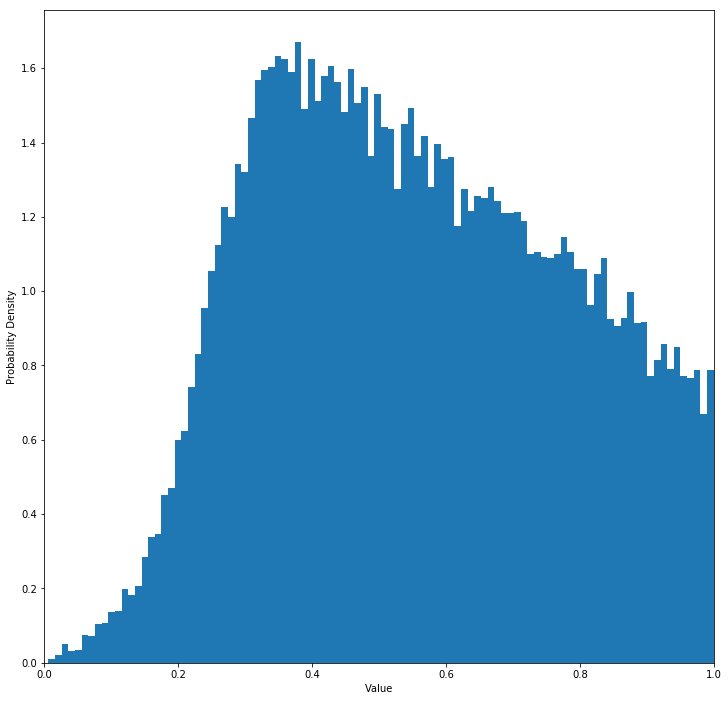

In [5]:
print("Alice's average win percentage: ", sum(alice_return)/len(alice_return))
ax, fig = plt.subplots(figsize=(12,12))
plt.hist(np.array(winning_vals), bins=100, normed=True)
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.xlim([0,1])
plt.show()

So as we suspected, Alice's win percentage is around 54%, which is comfortably beter than Bob. A cursory look a the batches indicates that Alice kicks the tar out of Bob's random policy, and rarely drops below 50%. In some cases, her win percentage can spike as high as 70%. We can also see the the values that win the most often, and note that the peak occurs somewhere between 0.3 and 0.4. Given any two values, you can figure out by looking at this chart which one you should pick if you want to maximize your odds of winning.

### Charlie and Bob Duke It Out
Next up, we'll train two policies adversarially. Bob and Charlie have beef with one another -- Bob is freaked out by Charlie's red hair, and Charlie has picked up on this, and lets his dog crap on Bob's front lawn. Rather than fence his property, Bob has agreed on Alice's suggestion to settle his differences with Charlie in a game of skill. Oddly enough, the very game that Alice and Bob use to determine who does the dishes. The stakes are high, because Bob is trying to salvage his failing marriage to Alice, and there's evidence to suggest that Alice may in fact be into redheads.

This scenario is the same as last time, except now Bob is no longer using a random policy. Instead, both players are attempting to maximize their respective scores in order to beat their opponent. We now have two policies -- one for Bob, and one for Charlie -- both parameterized by neural nets as we did with Alice. The only major difference is that we'll be drawing from and and updating both policies at the same time. The rules of the game haven't changed, so as before, both players only have access to their own two numbers. Since this is serious business, we'll up the number of iterations; Bob and Charlie are now stuck in a best-of-150,000 two player game.

In [6]:
print()
print("Initializing Bob's policy")
print("Initializing Charlie's policy")
policy_bob = Policy(2,128,2)
policy_charlie = Policy(2,128,2)
opt_bob = optim.Adam(policy_bob.parameters(),lr=1e-2)
opt_charlie = optim.Adam(policy_charlie.parameters(),lr=1e-2)
print("Running Bob versus Charlie")
charlie_return = []
bob_return = []
charlie_winning_vals = []
bob_winning_vals = []
for i in range(1500):
    rewards_charlie, logprobs_charlie = [], []
    rewards_bob, logprobs_bob = [], []
    for j in range(100):
        charlie, bob = generate_numbers()
        action_charlie, logprob_charlie = policy_alice.select_action(alice)
        action_bob, logprob_bob = policy_bob.select_action(bob)
        num_charlie = map_action(charlie, action_charlie)
        num_bob = map_action(bob, action_bob)
        win_charlie, win_bob = get_winner(num_charlie, num_bob)
        if win_charlie: charlie_winning_vals.append(num_charlie)
        if win_bob: bob_winning_vals.append(num_bob)
        rewards_charlie.append(win_charlie)
        rewards_bob.append(win_bob)
        logprobs_charlie.append(logprob_charlie)
        logprobs_bob.append(logprob_bob)
    batch_charlie = {"rewards": rewards_charlie,
                    "logprobs": logprobs_charlie}
    batch_bob = {"rewards": rewards_bob,
                    "logprobs": logprobs_bob}
    policy_charlie.update(opt_charlie, batch_charlie)
    policy_bob.update(opt_bob, batch_bob)
    wp_charlie = sum(rewards_charlie)/len(rewards_charlie)
    wp_bob = sum(rewards_bob)/len(rewards_bob)
    charlie_return.append(wp_charlie)
    bob_return.append(wp_bob)
    print("Batch {}  \t||  \tCharlie's wins: {:.2f}%, \tBob's wins: {:.2f}%".format(i+1, wp_charlie*100, wp_bob*100))



Initializing Bob's policy
Initializing Charlie's policy
Running Bob versus Charlie
Batch 1  	||  	Charlie's wins: 55.00%, 	Bob's wins: 45.00%
Batch 2  	||  	Charlie's wins: 60.00%, 	Bob's wins: 40.00%
Batch 3  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 4  	||  	Charlie's wins: 58.00%, 	Bob's wins: 42.00%
Batch 5  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 6  	||  	Charlie's wins: 57.00%, 	Bob's wins: 43.00%
Batch 7  	||  	Charlie's wins: 57.00%, 	Bob's wins: 43.00%
Batch 8  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 9  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 10  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 11  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 12  	||  	Charlie's wins: 55.00%, 	Bob's wins: 45.00%
Batch 13  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 14  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 15  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 16  	||  	Charlie's

Batch 136  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 137  	||  	Charlie's wins: 56.00%, 	Bob's wins: 44.00%
Batch 138  	||  	Charlie's wins: 55.00%, 	Bob's wins: 45.00%
Batch 139  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 140  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 141  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 142  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 143  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 144  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 145  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 146  	||  	Charlie's wins: 56.00%, 	Bob's wins: 44.00%
Batch 147  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 148  	||  	Charlie's wins: 38.00%, 	Bob's wins: 62.00%
Batch 149  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 150  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 151  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 152  	||  	Charlie

Batch 271  	||  	Charlie's wins: 60.00%, 	Bob's wins: 40.00%
Batch 272  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 273  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 274  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 275  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 276  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 277  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 278  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 279  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 280  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 281  	||  	Charlie's wins: 54.00%, 	Bob's wins: 46.00%
Batch 282  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 283  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 284  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 285  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 286  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 287  	||  	Charlie

Batch 407  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 408  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 409  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 410  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 411  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 412  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 413  	||  	Charlie's wins: 57.00%, 	Bob's wins: 43.00%
Batch 414  	||  	Charlie's wins: 42.00%, 	Bob's wins: 58.00%
Batch 415  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 416  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 417  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 418  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 419  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 420  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 421  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 422  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 423  	||  	Charlie

Batch 542  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 543  	||  	Charlie's wins: 59.00%, 	Bob's wins: 41.00%
Batch 544  	||  	Charlie's wins: 54.00%, 	Bob's wins: 46.00%
Batch 545  	||  	Charlie's wins: 54.00%, 	Bob's wins: 46.00%
Batch 546  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 547  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 548  	||  	Charlie's wins: 56.00%, 	Bob's wins: 44.00%
Batch 549  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 550  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 551  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 552  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 553  	||  	Charlie's wins: 61.00%, 	Bob's wins: 39.00%
Batch 554  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 555  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 556  	||  	Charlie's wins: 54.00%, 	Bob's wins: 46.00%
Batch 557  	||  	Charlie's wins: 61.00%, 	Bob's wins: 39.00%
Batch 558  	||  	Charlie

Batch 677  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 678  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 679  	||  	Charlie's wins: 42.00%, 	Bob's wins: 58.00%
Batch 680  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 681  	||  	Charlie's wins: 37.00%, 	Bob's wins: 63.00%
Batch 682  	||  	Charlie's wins: 33.00%, 	Bob's wins: 67.00%
Batch 683  	||  	Charlie's wins: 34.00%, 	Bob's wins: 66.00%
Batch 684  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 685  	||  	Charlie's wins: 54.00%, 	Bob's wins: 46.00%
Batch 686  	||  	Charlie's wins: 42.00%, 	Bob's wins: 58.00%
Batch 687  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 688  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 689  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 690  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 691  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 692  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 693  	||  	Charlie

Batch 814  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 815  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 816  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 817  	||  	Charlie's wins: 47.00%, 	Bob's wins: 53.00%
Batch 818  	||  	Charlie's wins: 56.00%, 	Bob's wins: 44.00%
Batch 819  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 820  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 821  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 822  	||  	Charlie's wins: 47.00%, 	Bob's wins: 53.00%
Batch 823  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 824  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 825  	||  	Charlie's wins: 36.00%, 	Bob's wins: 64.00%
Batch 826  	||  	Charlie's wins: 42.00%, 	Bob's wins: 58.00%
Batch 827  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 828  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 829  	||  	Charlie's wins: 34.00%, 	Bob's wins: 66.00%
Batch 830  	||  	Charlie

Batch 949  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 950  	||  	Charlie's wins: 36.00%, 	Bob's wins: 64.00%
Batch 951  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 952  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 953  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 954  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 955  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 956  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 957  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 958  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 959  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 960  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 961  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 962  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 963  	||  	Charlie's wins: 42.00%, 	Bob's wins: 58.00%
Batch 964  	||  	Charlie's wins: 32.00%, 	Bob's wins: 68.00%
Batch 965  	||  	Charlie

Batch 1082  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 1083  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 1084  	||  	Charlie's wins: 38.00%, 	Bob's wins: 62.00%
Batch 1085  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 1086  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 1087  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 1088  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1089  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 1090  	||  	Charlie's wins: 55.00%, 	Bob's wins: 45.00%
Batch 1091  	||  	Charlie's wins: 50.00%, 	Bob's wins: 50.00%
Batch 1092  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 1093  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 1094  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 1095  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 1096  	||  	Charlie's wins: 53.00%, 	Bob's wins: 47.00%
Batch 1097  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 10

Batch 1215  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 1216  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1217  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 1218  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 1219  	||  	Charlie's wins: 38.00%, 	Bob's wins: 62.00%
Batch 1220  	||  	Charlie's wins: 42.00%, 	Bob's wins: 58.00%
Batch 1221  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 1222  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 1223  	||  	Charlie's wins: 45.00%, 	Bob's wins: 55.00%
Batch 1224  	||  	Charlie's wins: 34.00%, 	Bob's wins: 66.00%
Batch 1225  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 1226  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1227  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 1228  	||  	Charlie's wins: 47.00%, 	Bob's wins: 53.00%
Batch 1229  	||  	Charlie's wins: 37.00%, 	Bob's wins: 63.00%
Batch 1230  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 12

Batch 1350  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 1351  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 1352  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 1353  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1354  	||  	Charlie's wins: 43.00%, 	Bob's wins: 57.00%
Batch 1355  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 1356  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 1357  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1358  	||  	Charlie's wins: 47.00%, 	Bob's wins: 53.00%
Batch 1359  	||  	Charlie's wins: 35.00%, 	Bob's wins: 65.00%
Batch 1360  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 1361  	||  	Charlie's wins: 40.00%, 	Bob's wins: 60.00%
Batch 1362  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 1363  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 1364  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1365  	||  	Charlie's wins: 46.00%, 	Bob's wins: 54.00%
Batch 13

Batch 1484  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 1485  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 1486  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 1487  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 1488  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 1489  	||  	Charlie's wins: 35.00%, 	Bob's wins: 65.00%
Batch 1490  	||  	Charlie's wins: 55.00%, 	Bob's wins: 45.00%
Batch 1491  	||  	Charlie's wins: 39.00%, 	Bob's wins: 61.00%
Batch 1492  	||  	Charlie's wins: 48.00%, 	Bob's wins: 52.00%
Batch 1493  	||  	Charlie's wins: 44.00%, 	Bob's wins: 56.00%
Batch 1494  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 1495  	||  	Charlie's wins: 52.00%, 	Bob's wins: 48.00%
Batch 1496  	||  	Charlie's wins: 49.00%, 	Bob's wins: 51.00%
Batch 1497  	||  	Charlie's wins: 56.00%, 	Bob's wins: 44.00%
Batch 1498  	||  	Charlie's wins: 41.00%, 	Bob's wins: 59.00%
Batch 1499  	||  	Charlie's wins: 51.00%, 	Bob's wins: 49.00%
Batch 15

First we'll plot Charlie's "winningest" values below:

Charlie's return:  0.46890000000000015


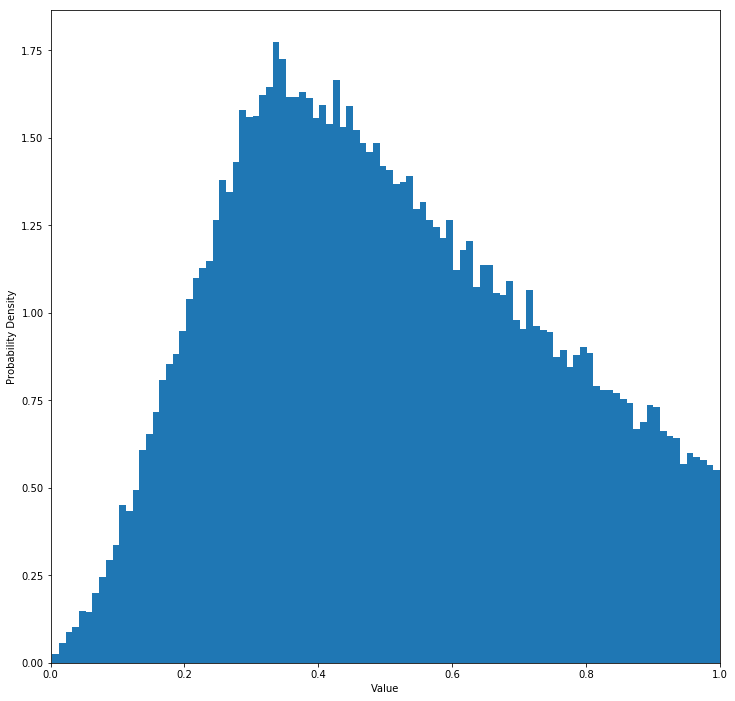

In [7]:
print("Charlie's return: ", sum(charlie_return)/len(charlie_return))
ax, fig = plt.subplots(figsize=(12,12))
plt.hist(np.array(charlie_winning_vals), bins=100, normed=True)
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.xlim([0,1])
plt.show()

And we'll do the same for Bob:

Bob's return:  0.5310999999999998


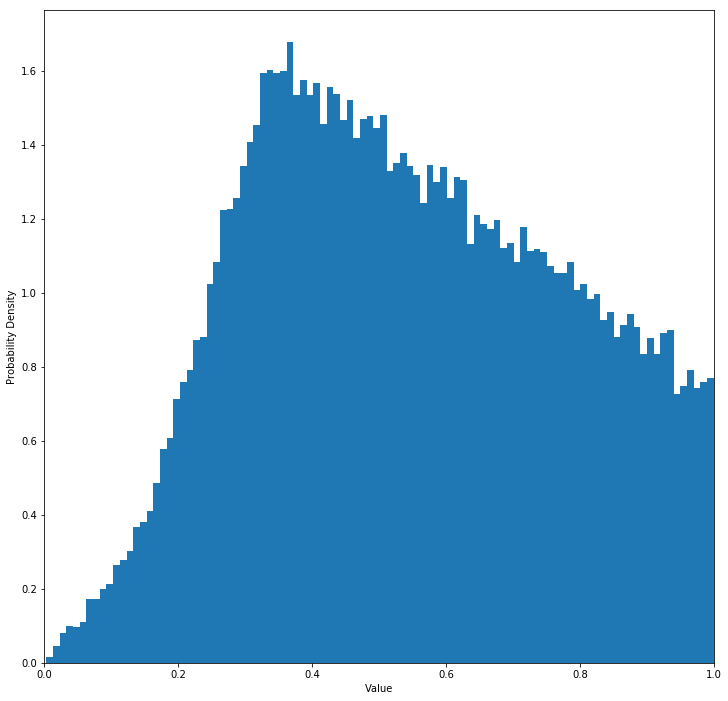

In [8]:
print("Bob's return: ", sum(bob_return)/len(bob_return))
ax, fig = plt.subplots(figsize=(12,12))
plt.hist(np.array(bob_winning_vals), bins=100, normed=True)
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.xlim([0,1])
plt.show()

Well that's very interesting.

It was a knife fight in a phone booth, but Bob -- in a heroic display of skill -- beats Charlie in this extended battle of wits. This is an interesting result, though, for two reasons. Firstly, because I've run this experiment a few times now, and each time it's converged on Bob beating Charlie. Maybe there's a mistake in the code? I'm not sure. Does it ever end up 50/50, or with Charlie stealing Alice from Bob? Secondly, the distribution of winning values is different for both players. Charlie's is completely different from Bob's, which looks a lot like Alice's.


### Alice Moves Out

Unfortunately for Bob, the marriage disintegrates anyway, and Alice moves into an apartment by herself. She dates Charlie briefly, but he turns out to be conceited, and so she decides to be alone for a bit. While in her apartment, Alice decides to see how she fares by playing against herself. Alice doesn't try to learn here, she just plays against herself to see how she would fare against an equally skilled opponent:

In [10]:
policy_alice = Policy(2, 128, 2)
opt_alice = optim.Adam(policy_alice.parameters(),lr=1e-2)
print("Running Alice versus herself")
alice_return = []
winning_vals = []
for i in range(300):
    rewards_alice = []
    for j in range(250):
        alice_one, alice_two = generate_numbers()
        action_one_alice, _ = policy_alice.select_action(alice_one)
        action_two_alice, _ = policy_alice.select_action(alice_two)
        num_one_alice = map_action(alice_one, action_one_alice)
        num_two_alice = map_action(alice_two, action_two_alice)
        win_alice_one, win_alice_two = get_winner(num_one_alice, num_two_alice)
        rewards_alice.append(win_alice_one)
        if win_alice_one: winning_vals.append(num_one_alice)
    wp_alice = sum(rewards_alice)/len(rewards_alice)
    alice_return.append(wp_alice)
    print("Batch {}  \t||  \tAlice's wins: {:.2f}%, \tAlice's wins: {:.2f}%".format(i+1, wp_alice*100, 100*(1-wp_alice)))

Running Alice versus herself
Batch 1  	||  	Alice's wins: 47.60%, 	Alice's wins: 52.40%
Batch 2  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 3  	||  	Alice's wins: 53.60%, 	Alice's wins: 46.40%
Batch 4  	||  	Alice's wins: 52.80%, 	Alice's wins: 47.20%
Batch 5  	||  	Alice's wins: 50.40%, 	Alice's wins: 49.60%
Batch 6  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 7  	||  	Alice's wins: 49.20%, 	Alice's wins: 50.80%
Batch 8  	||  	Alice's wins: 46.00%, 	Alice's wins: 54.00%
Batch 9  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 10  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 11  	||  	Alice's wins: 47.20%, 	Alice's wins: 52.80%
Batch 12  	||  	Alice's wins: 44.80%, 	Alice's wins: 55.20%
Batch 13  	||  	Alice's wins: 44.40%, 	Alice's wins: 55.60%
Batch 14  	||  	Alice's wins: 48.40%, 	Alice's wins: 51.60%
Batch 15  	||  	Alice's wins: 56.00%, 	Alice's wins: 44.00%
Batch 16  	||  	Alice's wins: 48.40%, 	Alice's wins: 51.60%
Batch 17  	||  	Alic

Batch 138  	||  	Alice's wins: 48.80%, 	Alice's wins: 51.20%
Batch 139  	||  	Alice's wins: 50.40%, 	Alice's wins: 49.60%
Batch 140  	||  	Alice's wins: 48.40%, 	Alice's wins: 51.60%
Batch 141  	||  	Alice's wins: 50.40%, 	Alice's wins: 49.60%
Batch 142  	||  	Alice's wins: 45.60%, 	Alice's wins: 54.40%
Batch 143  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 144  	||  	Alice's wins: 45.20%, 	Alice's wins: 54.80%
Batch 145  	||  	Alice's wins: 52.00%, 	Alice's wins: 48.00%
Batch 146  	||  	Alice's wins: 51.20%, 	Alice's wins: 48.80%
Batch 147  	||  	Alice's wins: 44.40%, 	Alice's wins: 55.60%
Batch 148  	||  	Alice's wins: 48.00%, 	Alice's wins: 52.00%
Batch 149  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 150  	||  	Alice's wins: 46.80%, 	Alice's wins: 53.20%
Batch 151  	||  	Alice's wins: 50.00%, 	Alice's wins: 50.00%
Batch 152  	||  	Alice's wins: 51.60%, 	Alice's wins: 48.40%
Batch 153  	||  	Alice's wins: 48.80%, 	Alice's wins: 51.20%
Batch 154  	||  	Alice's

Batch 273  	||  	Alice's wins: 53.20%, 	Alice's wins: 46.80%
Batch 274  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 275  	||  	Alice's wins: 46.40%, 	Alice's wins: 53.60%
Batch 276  	||  	Alice's wins: 49.20%, 	Alice's wins: 50.80%
Batch 277  	||  	Alice's wins: 46.80%, 	Alice's wins: 53.20%
Batch 278  	||  	Alice's wins: 45.60%, 	Alice's wins: 54.40%
Batch 279  	||  	Alice's wins: 55.20%, 	Alice's wins: 44.80%
Batch 280  	||  	Alice's wins: 45.60%, 	Alice's wins: 54.40%
Batch 281  	||  	Alice's wins: 55.60%, 	Alice's wins: 44.40%
Batch 282  	||  	Alice's wins: 53.60%, 	Alice's wins: 46.40%
Batch 283  	||  	Alice's wins: 48.80%, 	Alice's wins: 51.20%
Batch 284  	||  	Alice's wins: 52.00%, 	Alice's wins: 48.00%
Batch 285  	||  	Alice's wins: 52.80%, 	Alice's wins: 47.20%
Batch 286  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 287  	||  	Alice's wins: 46.80%, 	Alice's wins: 53.20%
Batch 288  	||  	Alice's wins: 49.20%, 	Alice's wins: 50.80%
Batch 289  	||  	Alice's

So Alice has a solid 50% win rate against herself, which is to be expected, but what does the winning distribution look like in this case?

Alice's average win percentage:  0.5003600000000001


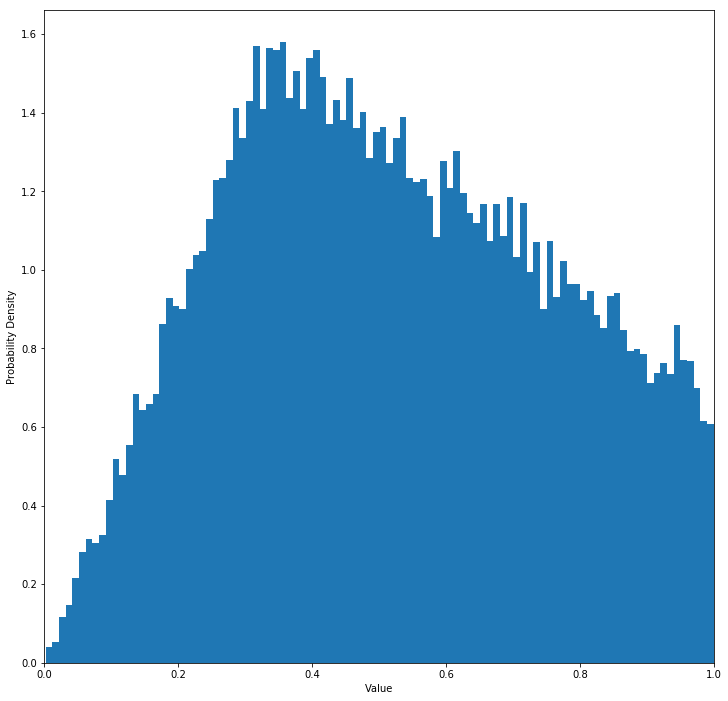

In [12]:
print("Alice's average win percentage: ", sum(alice_return)/len(alice_return))
ax, fig = plt.subplots(figsize=(12,12))
plt.hist(np.array(winning_vals), bins=100, normed=True)
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.xlim([0,1])
plt.show()

So this is what the distribution of winning values looks like when both players use the same better-than-random policy. Now, is it possible that Alice can improve by playing against herself? I don't know the answer, but I think we're about to find out.

In [13]:
policy_alice = Policy(2, 128, 2)
opt_alice = optim.Adam(policy_alice.parameters(),lr=1e-2)
print("Running Alice versus random policy")
alice_return = []
winning_vals = []
for i in range(300):
    rewards_alice, logprobs_alice = [], []
    one_side = []
    for j in range(250):
        alice_one, alice_two = generate_numbers()
        action_one_alice, logprob_alice_one = policy_alice.select_action(alice_one)
        action_two_alice, logprob_alice_two = policy_alice.select_action(alice_two)
        num_one_alice = map_action(alice_one, action_one_alice)
        num_two_alice = map_action(alice_two, action_two_alice)
        win_alice_one, win_alice_two = get_winner(num_one_alice, num_two_alice)
        if win_alice_one: 
            one_side.append(win_alice_one)
            winning_vals.append(num_one_alice)
            rewards_alice.append(win_alice_one)
            logprobs_alice.append(logprob_alice_one)
        else:
            winning_vals.append(num_two_alice)
            rewards_alice.append(win_alice_two)
            logprobs_alice.append(logprob_alice_two)
    batch_alice = {"rewards": rewards_alice,
                    "logprobs": logprobs_alice}
    policy_alice.update(opt_alice, batch_alice)
    wp_alice = sum(one_side)/len(rewards_alice)
    alice_return.append(wp_alice)
    print("Batch {}  \t||  \tAlice's wins: {:.2f}%, \tAlice's wins: {:.2f}%".format(i+1, wp_alice*100, 100*(1-wp_alice)))

Running Alice versus random policy
Batch 1  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 2  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 3  	||  	Alice's wins: 46.00%, 	Alice's wins: 54.00%
Batch 4  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 5  	||  	Alice's wins: 50.80%, 	Alice's wins: 49.20%
Batch 6  	||  	Alice's wins: 43.60%, 	Alice's wins: 56.40%
Batch 7  	||  	Alice's wins: 46.00%, 	Alice's wins: 54.00%
Batch 8  	||  	Alice's wins: 50.80%, 	Alice's wins: 49.20%
Batch 9  	||  	Alice's wins: 49.20%, 	Alice's wins: 50.80%
Batch 10  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 11  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 12  	||  	Alice's wins: 48.80%, 	Alice's wins: 51.20%
Batch 13  	||  	Alice's wins: 51.20%, 	Alice's wins: 48.80%
Batch 14  	||  	Alice's wins: 47.60%, 	Alice's wins: 52.40%
Batch 15  	||  	Alice's wins: 46.80%, 	Alice's wins: 53.20%
Batch 16  	||  	Alice's wins: 51.20%, 	Alice's wins: 48.80%
Batch 17  	|| 

Batch 137  	||  	Alice's wins: 48.00%, 	Alice's wins: 52.00%
Batch 138  	||  	Alice's wins: 50.40%, 	Alice's wins: 49.60%
Batch 139  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 140  	||  	Alice's wins: 48.00%, 	Alice's wins: 52.00%
Batch 141  	||  	Alice's wins: 50.80%, 	Alice's wins: 49.20%
Batch 142  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 143  	||  	Alice's wins: 47.20%, 	Alice's wins: 52.80%
Batch 144  	||  	Alice's wins: 58.40%, 	Alice's wins: 41.60%
Batch 145  	||  	Alice's wins: 45.60%, 	Alice's wins: 54.40%
Batch 146  	||  	Alice's wins: 52.00%, 	Alice's wins: 48.00%
Batch 147  	||  	Alice's wins: 46.00%, 	Alice's wins: 54.00%
Batch 148  	||  	Alice's wins: 52.00%, 	Alice's wins: 48.00%
Batch 149  	||  	Alice's wins: 48.40%, 	Alice's wins: 51.60%
Batch 150  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 151  	||  	Alice's wins: 44.00%, 	Alice's wins: 56.00%
Batch 152  	||  	Alice's wins: 48.80%, 	Alice's wins: 51.20%
Batch 153  	||  	Alice's

Batch 272  	||  	Alice's wins: 51.60%, 	Alice's wins: 48.40%
Batch 273  	||  	Alice's wins: 54.80%, 	Alice's wins: 45.20%
Batch 274  	||  	Alice's wins: 51.60%, 	Alice's wins: 48.40%
Batch 275  	||  	Alice's wins: 56.80%, 	Alice's wins: 43.20%
Batch 276  	||  	Alice's wins: 46.00%, 	Alice's wins: 54.00%
Batch 277  	||  	Alice's wins: 54.80%, 	Alice's wins: 45.20%
Batch 278  	||  	Alice's wins: 48.80%, 	Alice's wins: 51.20%
Batch 279  	||  	Alice's wins: 52.00%, 	Alice's wins: 48.00%
Batch 280  	||  	Alice's wins: 50.40%, 	Alice's wins: 49.60%
Batch 281  	||  	Alice's wins: 49.60%, 	Alice's wins: 50.40%
Batch 282  	||  	Alice's wins: 52.40%, 	Alice's wins: 47.60%
Batch 283  	||  	Alice's wins: 46.40%, 	Alice's wins: 53.60%
Batch 284  	||  	Alice's wins: 50.80%, 	Alice's wins: 49.20%
Batch 285  	||  	Alice's wins: 44.00%, 	Alice's wins: 56.00%
Batch 286  	||  	Alice's wins: 50.40%, 	Alice's wins: 49.60%
Batch 287  	||  	Alice's wins: 52.00%, 	Alice's wins: 48.00%
Batch 288  	||  	Alice's

And of course the plot and win percentage:

Alice's average win percentage:  0.5008133333333336


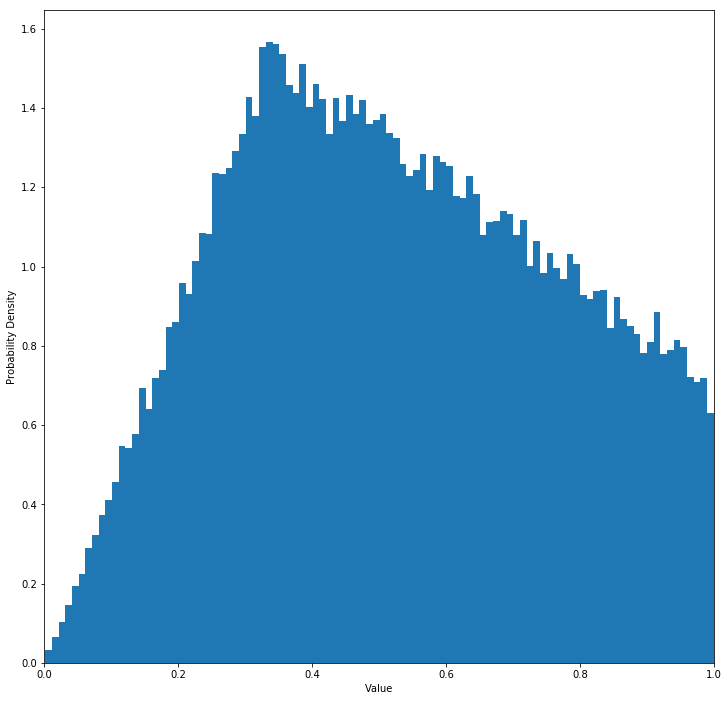

In [14]:
print("Alice's average win percentage: ", sum(alice_return)/len(alice_return))
ax, fig = plt.subplots(figsize=(12,12))
plt.hist(np.array(winning_vals), bins=100, normed=True)
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.xlim([0,1])
plt.show()

And that's all for today. Let me know if there are any mistakes in the code, or any insights you think might shed some more light on this game.

Cheers!

Sean